In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns

In [3]:
from IPython.display import clear_output
import json

In [4]:
from sklearn.cluster import AgglomerativeClustering, KMeans

In [5]:
from utils.clustering import get_lda_clusters, get_vocab, word_topics_clustering, sort_meaningful, get_trf_clusters, topic_count
from utils.clustering_evaluation import get_characters_with_tv_trop_info, variation_of_information, group_labels_by_clusters

# Clustering methods comparison

We use Variation of Information between our clusters and golden clusters from TV Tropes as suggested in [Learning Latent Personas of Film Characters](http://www.cs.cmu.edu/~dbamman/pubs/pdf/bamman+oconnor+smith.acl13.pdf). This way we can compare our methods' performance with the original method performance.

### LDA based clustering
For the character names and linguistic features extraction pipeline, please refer to `extract_character_attributes.ipynb`.

In [6]:
characters_attributes =  pd.read_csv(
    'data/character_attributes.csv', 
    index_col=0,
    converters={
        "adj": lambda x: x.strip("[]").replace("'","").split(", "), # need this to read list columns from csv
        "active": lambda x: x.strip("[]").replace("'","").split(", "),
        "patient": lambda x: x.strip("[]").replace("'","").split(", ")
        }
    )
# select only the characters who have at least 3 liguistic features
characters_attributes = sort_meaningful(characters_attributes, 3)

characters_attributes.head()

,wiki_id,character,adj,active,patient
0,31186339,Peeta Mellark,[son],"[take, reveal, mean, form, present, beg, tell]",[force]
1,31186339,Cato,[],[kill],"[encounter, wound, shoot]"
2,31186339,Katniss,[],"[take, survive, drop, warn, run, shoot, presen...","[give, find, torment, spare, force, tell, warn]"
3,31186339,Rue,[die],"[draw, care, draw, trap]","[hear, stab, comfort, kill]"
4,31186339,Seneca Crane,[Gamemaker],"[change, lock]","[summon, convince]"


In [7]:
characters_to_check, tv_tropes = get_characters_with_tv_trop_info(characters_attributes)

In [8]:
agglomerative_clusters_n = [25, 50, 100]
n_components = [25, 50, 100]

configs = {}
config_base = {'characters': characters_to_check, 'min_freq': 5, 'max_freq':0.9}

for alg_n in agglomerative_clusters_n:
    for n in n_components:
        config = config_base.copy()
        config['clustering_algo'] = AgglomerativeClustering(n_clusters=alg_n, metric='cosine', linkage='complete')
        config['n_components'] = n
        configs[f'{alg_n} topics, {n} archetypes'] = config

results_lda = {}
for k, config in configs.items():
    clusters = get_lda_clusters(**config)
    results_lda[k] = variation_of_information(group_labels_by_clusters(clusters), tv_tropes)
    print(k, f'VI = {results_lda[k]}')

clear_output(wait=True)
results_lda

{'25 topics, 25 archetypes': 6.2466797099799205,
 '25 topics, 50 archetypes': 5.721030072070011,
 '25 topics, 100 archetypes': 5.19585126544422,
 '50 topics, 25 archetypes': 6.3319648575061835,
 '50 topics, 50 archetypes': 5.666473591455292,
 '50 topics, 100 archetypes': 4.976150571899939,
 '100 topics, 25 archetypes': 6.349160556531042,
 '100 topics, 50 archetypes': 5.607356379575675,
 '100 topics, 100 archetypes': 4.898739702618948}

Note, that the results are even better (K=100, P=100, 5.42 in the paper and 4.9 here) than the results from the [paper](http://www.cs.cmu.edu/~dbamman/pubs/pdf/bamman+oconnor+smith.acl13.pdf). That could indicate that using word2vec embeddings and Agglomerative clustering of the words to topics might be better suited for dividing the words into topics for the purpose of personas extraction.

### BERT based clustering

For the embedding extraction see `utils/archive/transformer_embeddings.ipynb`

In [9]:
characters_with_trf_emb =  pd.read_csv(
    'data/trf_embeddings_for_labeled_characters.csv', 
    index_col=0,
    converters={
        "emb": lambda x: [float(k) for k in x.strip("[]").replace("'","").split(", ")]
        }
    )
# Leave only those, who we compared on the previous step
characters_with_trf_emb = characters_with_trf_emb[characters_with_trf_emb['wiki_id'].isin(characters_to_check['wiki_id'].values)]

characters_with_trf_emb.head()

,wiki_id,character,emb
0,6002183,Horton,"[1.0488402843475342, 0.3811729848384857, 0.645..."
1,6002183,Ned McDodd,"[-0.5622232556343079, -0.2521360516548157, -0...."
2,6002183,JoJo,"[-0.7999439835548401, -0.4102073311805725, 0.6..."
3,6002183,Sally,"[0.7803803086280823, -0.7006192207336426, 0.32..."
4,6002183,LaRue,"[-0.038770418614149094, 0.219954714179039, -0...."


In [10]:
characters_to_check_trf, tv_tropes = get_characters_with_tv_trop_info(characters_with_trf_emb)

In [11]:
results_trf = {}
for n in n_components:
    k = f'{n} archetypes, agglomerative clustering'
    agglomerative = AgglomerativeClustering(n_clusters=n, metric='euclidean', linkage='complete')
    clusters = get_trf_clusters(characters_to_check_trf, agglomerative)
    results_trf[k] = variation_of_information(group_labels_by_clusters(clusters), tv_tropes)
    print(k, f'VI = {results_trf[k]}')

    k = f'{n} archetypes, kmeans clustering'
    kmeans = KMeans(n_clusters=n)
    clusters = get_trf_clusters(characters_to_check_trf, kmeans)
    results_trf[k] = variation_of_information(group_labels_by_clusters(clusters), tv_tropes)
    print(k, f'VI = {results_trf[k]}')

clear_output(wait=True)
results_trf

{'25 archetypes, agglomerative clustering': 6.126084917715467,
 '25 archetypes, kmeans clustering': 6.295811056950473,
 '50 archetypes, agglomerative clustering': 5.5954496618130625,
 '50 archetypes, kmeans clustering': 5.594318343968197,
 '100 archetypes, agglomerative clustering': 4.936886689856702,
 '100 archetypes, kmeans clustering': 4.8017551145531066}

The results of BERT embeddings based clustering are also better than the results from the paper. Still, obtaining these embeddings is slow, and the difference between this and previous method is not that big, so we will stick to the faster and more interpretable LDA based method.

**Comparison Table**
|                        |Paper K=100, P=100| LDA-based clustering  K=100, P=100| BERT-based kmeans clustering P=100|
|------------------------|------------------|-----------------------------------|-----------------------------------|
|Variation of Information|              5.42|                               4.90|                              ~4.80|


# Loading the data

For the clusterization pipeline as well as the different clustering methods comparison refer to `clustering.ipynb`. For our initial analysis we will use 50 clusters.

In [12]:
characters =  pd.read_csv(
    'data/character_clusters.csv', 
    index_col=0,
    converters={
        "adj": lambda x: x.strip("[]").replace("'","").split(", "), # need this to read list columns from csv
        "active": lambda x: x.strip("[]").replace("'","").split(", "),
        "patient": lambda x: x.strip("[]").replace("'","").split(", ")
        }
    )
characters.head()

,wiki_id,character,adj,active,patient,cluster
0,31186339,Peeta Mellark,[son],"[take, reveal, mean, form, present, beg, tell]",[force],29
1,31186339,Cato,[],[kill],"[encounter, wound, shoot]",15
2,31186339,Katniss,[],"[take, survive, drop, warn, run, shoot, presen...","[give, find, torment, spare, force, tell, warn]",9
3,31186339,Rue,[die],"[draw, care, draw, trap]","[hear, stab, comfort, kill]",1
4,31186339,Seneca Crane,[Gamemaker],"[change, lock]","[summon, convince]",14


In [13]:
print(f"In the clustered characters dataframe there are {len(characters)} characters from {len(set(characters['wiki_id'].values))} movies")

In the clustered characters dataframe there are 74842 characters from 25664 movies


In [14]:
movies = pd.read_csv(
    'data/MovieSummaries/movie.metadata.tsv', 
    sep='\t', 
    names=['wiki_id', 'freebase_id', 'title', 'release_date', 'revenue', 'runtime', 'languages', 'countries', 'genres']
)

In [15]:
characters_and_movies = characters.merge(movies, how='left', on='wiki_id')
characters_and_movies = characters_and_movies[characters_and_movies['revenue'].notna()]

print(f"In the clustered characters with movie metadata dataframe there are {len(characters_and_movies)} characters from {len(set(characters_and_movies['wiki_id'].values))} movies with the revenue data")

In the clustered characters with movie metadata dataframe there are 23911 characters from 6280 movies with the revenue data


In [16]:
characters_and_movies.sample(3)

,wiki_id,character,adj,active,patient,cluster,freebase_id,title,release_date,revenue,runtime,languages,countries,genres
49668,1709334,Tex Warner,[entertainer],"[want, see, return]",[want],22,/m/01hz1gx,Loving You,1957-07-09,3700000.0,102.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/068d7h"": ""Romantic drama"", ""/m/04t36"": ""M..."
23933,217783,Jerry Payne,[],"[see, begin, fall, want, realize]","[meet, tell]",16,/m/01fx0w,The Sterile Cuckoo,1969-10-22,13982357.0,107.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/01j1n2"": ""..."
9340,2941852,Ernest,"[one, then, rifle]","[get, take, decide, beat, make, mend, plan, kn...","[manipulate, use, talk, target]",14,/m/08f40v,Ernest Goes to Camp,1987-05-22,23509382.0,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hqxf"": ""Family Film"", ""/m/01z4y"": ""Comed..."


In [17]:
characters_and_movies[characters_and_movies['title'].str.contains("Batman")][['title', 'character', 'cluster']]

,title,character,cluster
6348,Superman/Batman: Apocalypse,Superman,42
6349,Superman/Batman: Apocalypse,Batman,42
6350,Superman/Batman: Apocalypse,Barda,30
6351,Superman/Batman: Apocalypse,Kara,42
6352,Superman/Batman: Apocalypse,Darkseid,23
...,...,...,...
69321,Batman Forever,Riddler,42
69322,Batman Forever,Batman,42
69323,Batman Forever,Edward Nygma,17
69324,Batman Forever,Bruce Wayne,41


We can notice, that, probably, cluster number 42 is the cluster of super-heroes.

## Clusters interpretability
For now we won't give particular names to each cluster. But we show, how to use data from Latent Dirichlet Allocation model to understand what is the meaning of each cluster. We can look at the most important topics (groups of words) for each cluster and conclude, what is the role of the character form a particular cluster. 

In [18]:
topics_dict = json.load(open('data/words_by_topic.json', 'r'))
lda_components = np.load('data/lda_components.npy')

In [19]:
for i in range(0, 50, 10):
    idx = lda_components[i].argmax()
    feature_type = 'attribute'
    if idx // 200 == 1:
        feature_type = 'active verb'
    elif idx // 200 == 2:
        feature_type = 'patient verb'
    print(f'For the cluster {i}, the most important topic is {feature_type} from')
    print(topics_dict[str(idx % 200)])
    print()

For the cluster 0, the most important topic is patient verb from
['ascend', 'bash', 'chase', 'climb', 'hit', 'jump', 'kick', 'knock', 'leap', 'move', 'nudge', 'pass', 'pull', 'push', 'run', 'slam', 'smash', 'step', 'turn']

For the cluster 10, the most important topic is attribute from
['alia', 'alias', 'aunt', 'babysit', 'babysitter', 'barmaid', 'betrothed', 'butler', 'codename', 'cousin', 'daughter', 'dote', 'elder', 'fiancee', 'fiancé', 'fiancée', 'goddaughter', 'granddaughter', 'grandson', 'housekeeper', 'husband', 'maid', 'name', 'nanny', 'nephew', 'nickname', 'niece', 'pseudonym', 'son', 'stepdaughter', 'stepson', 'uncle', 'widow', 'widowed', 'widower', 'wife']

For the cluster 20, the most important topic is active verb from
['accommodate', 'assemble', 'concoct', 'cover', 'decorate', 'divide', 'elaborate', 'equip', 'fabricate', 'follow', 'instal', 'install', 'merge', 'replace', 'replacement', 'set', 'split', 'unite', 'upgrade']

For the cluster 30, the most important topic is ac

For example, we can see, that characters in cluster 0 are the onces who move a lot, while in cluster 10 characters are usually someones relative and characters in cluster 40 are some authority figures. Further, we will look at the top topics for each cluster to interpret, what are the common traits of the characters in one cluster.

# Initial analysis of the actors' success

In [20]:
actors = pd.read_csv(
    'data/MovieSummaries/character.metadata.tsv', 
    sep='\t', 
    names=['wiki_id', 'freebase_id', 'release_date', 'character', 'date_of_birth', 'sex', 'height', '.','actor','age','character_map','..','...','....']
)
actors.head()

,wiki_id,freebase_id,release_date,character,date_of_birth,sex,height,.,actor,age,character_map,..,...,....
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,NaN
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN


In [21]:
map_dict_to_list = lambda x: [value for key, value in eval(x).items()]
movies['languages'] = movies['languages'].apply(map_dict_to_list)
movies['countries'] = movies['countries'].apply(map_dict_to_list)
movies['genres'] = movies['genres'].apply(map_dict_to_list)
movies.head()

,wiki_id,freebase_id,title,release_date,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]


### Determine which actors bring in the most money


In [22]:
# Merge the two datas
df_merged = actors.merge(movies, on=['wiki_id'], how='inner')

# Clean data of movies without box offic revenue
df_merged = df_merged.dropna(subset=['revenue'])

# Determine the actor and sum the box office revenue
actor_totalRevenue = df_merged.groupby(['actor'])['revenue'].agg(['sum', 'count']).reset_index()
actor_totalRevenue.columns = ['actor', 'bo_revenue', 'Actor Count']

# Sort the actor_revenue DataFrame in descending order
actor_revenue_sort = actor_totalRevenue.sort_values(by='bo_revenue', ascending=False)

#Extract only the top 20 best actors
actor_top20 = actor_revenue_sort.head(20)

# Merge the top 20 actors with original datas
top20_actor_data = actor_top20.merge(df_merged[['actor', 'languages','sex']], on='actor', how='left')
top20_actor_data = top20_actor_data.drop_duplicates(subset = ['actor'])
top20_actor_data.head()

,actor,bo_revenue,Actor Count,languages,sex
0,Warwick Davis,1.293016e+10,19,"[Croatian language, English Language]",M
19,Samuel L. Jackson,1.278943e+10,72,"[Russian Language, English Language]",M
91,Frank Welker,1.028744e+10,61,"[English Language, Spanish Language]",M
152,Alan Rickman,1.020871e+10,29,"[Croatian language, English Language]",M
181,Robbie Coltrane,1.009465e+10,30,"[Croatian language, English Language]",M


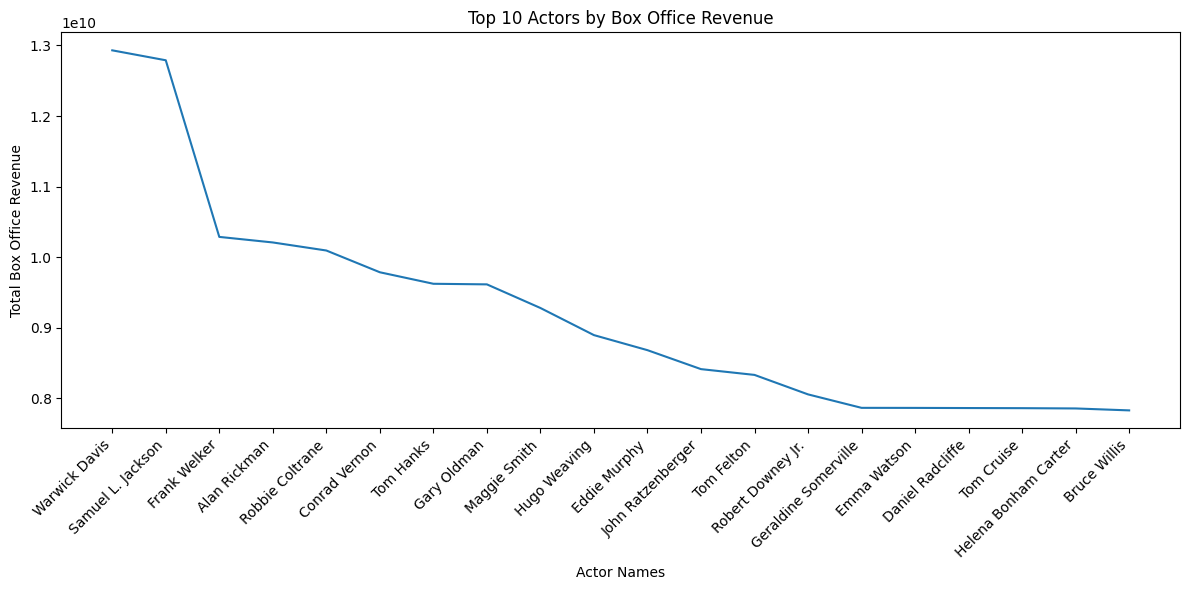

In [23]:
# Plot the data above
actor_names = top20_actor_data['actor']
revenues_total = top20_actor_data['bo_revenue']

plt.figure(figsize=(12, 6))
plt.plot(actor_names, revenues_total)
plt.xlabel('Actor Names')
plt.ylabel('Total Box Office Revenue')
plt.title('Top 10 Actors by Box Office Revenue')
plt.xticks(rotation=45, ha='right')  # Rotate the actor names for better readability

plt.tight_layout()
plt.show()



In the data above, we are ranking the actors according to the sum of box office revenue of the movies they acted in.

### Study the main lead actors obtaining the highest revenue

In [24]:
def calculater_importance(x):
    a = 0
    for w in x["adj"]:
        a += w.isalpha()
    for w in x["active"]:
        a += w.isalpha()
    for w in x["patient"]:
        a += w.isalpha()
    return a

characters['importance'] = characters.apply(calculater_importance, axis=1)

characters_with_importance = characters[['wiki_id', 'character', 'importance']]

In [25]:
characters_with_importance['importance_share'] = characters_with_importance['importance'] / characters_with_importance.groupby('wiki_id')['importance'].transform('sum')
characters_with_importance['is_important'] = characters_with_importance['importance_share'] >= 0.2
characters_with_importance.sample(10)

/tmp/ipykernel_2259/1073324314.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  characters_with_importance['importance_share'] = characters_with_importance['importance'] / characters_with_importance.groupby('wiki_id')['importance'].transform('sum')
/tmp/ipykernel_2259/1073324314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  characters_with_importance['is_important'] = characters_with_importance['importance_share'] >= 0.2


,wiki_id,character,importance,importance_share,is_important
72183,23856720,Eric,3,0.048387,False
68496,16555100,Babu,3,0.130435,False
41367,6816652,Brushogun,4,0.200000,True
58163,358363,Biddle,10,0.256410,True
7456,1850269,Ga Yu,5,0.454545,True
10244,11244593,Chipmunks,9,0.219512,True
67554,21639537,Jane,13,0.464286,True
43987,2411131,Carl Taylor,7,0.304348,True
5943,4832313,Maliss,20,0.224719,True
59722,22449964,Arthur Dyson,7,0.250000,True


In [26]:
df_charac_actor = df_merged[['wiki_id', 'character','actor','revenue']]

# Include characters and actors together in the same dataset
character_actor = df_charac_actor.merge(characters_with_importance, on=['wiki_id', 'character'], how='left')

# Merge only the main charac of movies\n",
main_character = character_actor[character_actor['is_important'] == True]

#Add up the Box office revenue and count the occurance of movie appearance
main_charac_mergedBOR = main_character.groupby(['actor'])['revenue'].agg(['sum', 'count']).reset_index()

main_charac_sort = main_charac_mergedBOR.sort_values(by='sum', ascending=False)

main_charac_top20 = main_charac_sort.head(20)
main_charac_top20.head()

,actor,sum,count
2263,Tom Cruise,5.690064e+09,19
520,Daniel Radcliffe,5.058613e+09,6
2265,Tom Hanks,4.577922e+09,18
1409,Leonardo DiCaprio,4.059193e+09,8
1595,Mel Gibson,4.048504e+09,22


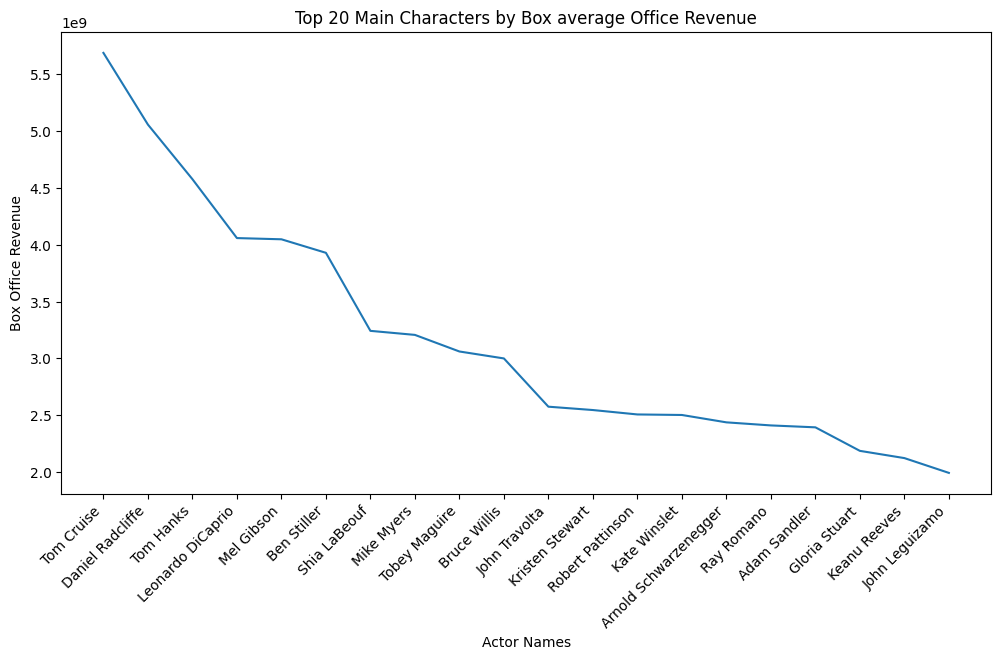

In [27]:
# Plot the charts for main actors\n",
main_charac_top20_names = main_charac_top20['actor']
main_charac_revenue = main_charac_top20['sum']

plt.figure(figsize=(12, 6))
plt.plot(main_charac_top20_names,main_charac_revenue)
plt.xlabel('Actor Names')
plt.ylabel('Box Office Revenue')
plt.title('Top 20 Main Characters by Box average Office Revenue')
plt.xticks(rotation=45, ha='right')  # Rotate the actor names for better readability

plt.show()

The top of the actors changed, and we see, that the actors look like those who we would expect to be successful (generally subjectively more famous than the previous top).

### Male or female perform better in generating box office revenue?

In [28]:
gender_actor_data = actor_revenue_sort.merge(actors[['actor', 'sex']], on='actor', how='left')
gender_actor_data = gender_actor_data.drop_duplicates(subset = ['actor'])
gender_actor_data.head()

,actor,bo_revenue,Actor Count,sex
0,Warwick Davis,1.293016e+10,19,M
31,Samuel L. Jackson,1.278943e+10,72,M
137,Frank Welker,1.028744e+10,61,M
320,Alan Rickman,1.020871e+10,29,M
362,Robbie Coltrane,1.009465e+10,30,M


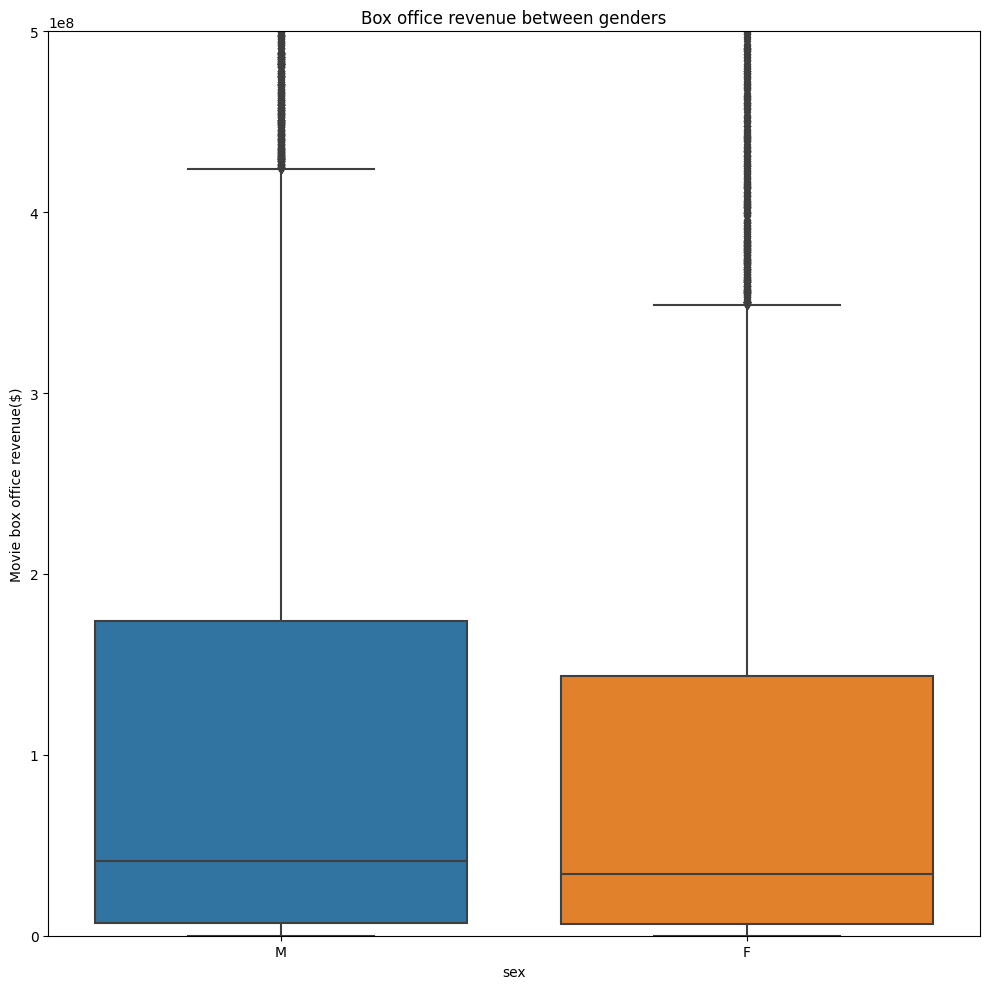

In [29]:
# Box plot for revenue between genders
plt.figure(figsize=(10, 10))
gender_boxplot = sns.boxplot(x="sex", y="bo_revenue", data=gender_actor_data.loc[gender_actor_data['sex'].isin(['M','F'])])

# Set labels
plt.ylabel("Movie box office revenue($)")
plt.title("Box office revenue between genders")
plt.ylim(0, 500000000)
          
#Show plot
plt.tight_layout()
plt.show()

# Given the variance and the 25th percentile, 75th percentile and medan, male actors drive higher box office revenue."

### Study the language used in top 50 films / Which language drive the highest revenue?

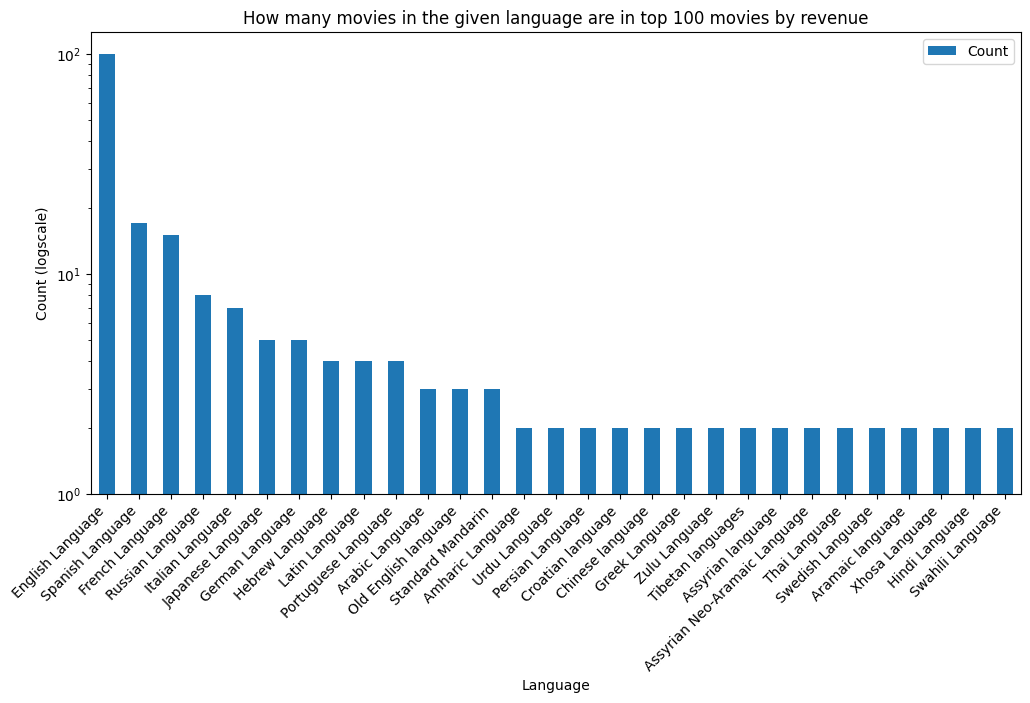

In [30]:
# Extract the top 100 movies
film_sort = df_merged[['countries','languages','revenue','wiki_id']]
film_sort = film_sort.drop_duplicates(subset = ['wiki_id'])
film_sort = film_sort.sort_values(by='revenue', ascending=False)
top100film = film_sort.head(100)

# Split the language into new data frames\
df_split_languages = top100film.explode('languages')

# Count the occurance of the languages
language_counts = df_split_languages['languages'].value_counts()
df_language_counts = pd.DataFrame({'Language': language_counts.index, 'Count': language_counts.values})

# Plot the data
df_language_counts.plot(kind='bar', x='Language', y='Count', figsize=(12, 6),log=True)
plt.title('How many movies in the given language are in top 100 movies by revenue')
plt.xlabel('Language')
plt.ylabel('Count (logscale)')
plt.xticks(rotation=45, ha='right')
plt.show()

Every top movie was translated to English. 

### Study the genre of movies that earn the highest revenue.

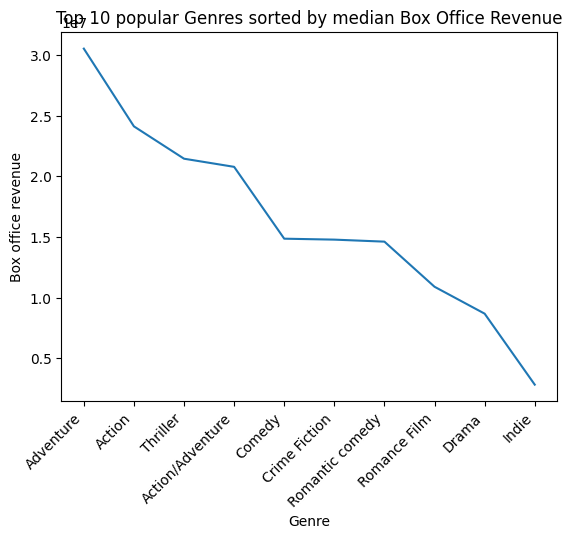

In [31]:
#Clean data to remove repeated movies
df_clean_split_genres = df_merged[['title','genres','revenue','wiki_id']]
df_clean_split_genres = df_clean_split_genres.drop_duplicates(subset = ['wiki_id'])

# Split the genre into new data frames
df_split_genre = df_clean_split_genres.explode('genres')[['title', 'revenue', 'genres']]

# Find top genres
top_genres = df_split_genre.groupby('genres').size().reset_index().sort_values(by=0, ascending=False)
top_genres = top_genres.head(10)['genres'].values

# Determine the actor and sum the box office revenue
genre_totalRevenue = df_split_genre[df_split_genre['genres'].isin(top_genres)].groupby('genres')['revenue'].median().reset_index()

# Sort the BOR in ascending order
genre_totalRevenue = genre_totalRevenue.sort_values(by='revenue', ascending=False)

genre = genre_totalRevenue['genres']
genreRevenue = genre_totalRevenue['revenue']

#Plot the charts
plt.plot(genre, genreRevenue)
plt.xlabel('Genre')
plt.ylabel('Box office revenue')
plt.title('Top 10 popular Genres sorted by median Box Office Revenue')
plt.xticks(rotation=45, ha='right')  # Rotate the actor names for better readability
plt.show()

# Genre-cluster correlation

In [32]:
characters_and_movies_with_genres = characters.merge(movies, how='left', on='wiki_id')
characters_and_movies_with_genres = characters_and_movies_with_genres[characters_and_movies_with_genres['genres'].notna()]
characters_and_movies_with_genres = characters_and_movies_with_genres[['wiki_id', 'title', 'character', 'cluster', 'genres']]
characters_and_movies_with_genres.sample(5)

,wiki_id,title,character,cluster,genres
47765,7643463,Double Dragon,Jimmy Lee,44,"[Science Fiction, Martial Arts Film]"
30856,35581515,Beasts of the Southern Wild,Aurochs,16,"[Fantasy, Drama]"
45758,2510954,An Unfinished Life,Mitch,46,"[Family Drama, Drama, Melodrama]"
53923,4248608,The Land Before Time X: The Great Longneck Mig...,Bron,2,"[Family Film, Animated cartoon, Adventure, Ani..."
1393,168554,Runaway Train,Ranken,36,"[Thriller, Crime Fiction, Adventure, Action Th..."


In [33]:
characters_and_movies_with_genres = characters_and_movies_with_genres.explode('genres')
characters_and_movies_with_genres = characters_and_movies_with_genres[characters_and_movies_with_genres['genres'].isin(top_genres)]
characters_and_movies_with_genres.sample(5)

,wiki_id,title,character,cluster,genres
68999,452767,Underworld,Viktor,12,Thriller
26380,3452126,Angel-A,Andre,24,Romance Film
2402,697113,Big Trouble in Little China,Egg Shen,19,Romance Film
13819,24544387,Worth Winning,Veronica Briskow,32,Comedy
57905,10433895,21,Cole Williams,24,Action/Adventure


In [34]:
cluster_genre_table = characters_and_movies_with_genres[['cluster', 'genres']].groupby(['cluster', 'genres']).size().reset_index()
cluster_genre_table = cluster_genre_table.pivot(index='cluster', columns='genres', values=0)
cluster_genre_table

genres,Action,Action/Adventure,Adventure,Comedy,Crime Fiction,Drama,Indie,Romance Film,Romantic comedy,Thriller
cluster,,,,,,,,,,
0,212,138,111,375,157,386,107,107,46,295
1,465,313,297,741,237,1076,175,538,211,383
2,500,345,250,776,413,1455,264,632,187,648
3,272,205,129,176,195,389,64,91,22,261
4,117,81,72,174,58,365,69,131,31,96
5,82,56,59,203,60,406,47,256,72,83
6,94,75,49,175,66,244,42,102,32,88
7,189,146,97,307,144,508,75,206,67,250
8,115,78,61,160,83,246,30,68,28,146


In [35]:
from scipy.stats import chi2_contingency

table = cluster_genre_table[['Romantic comedy', 'Thriller']].values
res = chi2_contingency(table)
print(f'pvalue of the test with H0: cluster distribution is the same in Romantic comedy	and Thriller films: {res[1]}')

pvalue of the test with H0: cluster distribution is the same in Romantic comedy	and Thriller films: 3.0525474221763344e-108


# Revenue prediction using clusters